In [24]:
from __future__ import print_function
import argparse
import torch
from PIL import Image
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import numpy as np

In [25]:
input_image = "super_resolution/dataset/BSDS300/images/test/119082.jpg" 
output_filename = "out.png"
dataset = 'BSD300'

#parser.add_argument('--cuda', action='store_true', help='use cuda')

In [26]:

if torch.cuda.is_available():
    device_name = 'cuda'
elif torch.backends.mps.is_available():
    device_name = 'mps'
else:
    device_name = 'cpu'
    
device = torch.device(device_name)
    
#torch.manual_seed(seed)

In [27]:
def load_model(model_name, dataset, epoch, factor, device_name):
    #print(model.state_dict()['conv1.W_mu'][0])
    
    model = torch.load(f'super_resolution/models/{model_name}/{dataset}/epoch_{epoch}_upscale_factor_{factor}_device_{device_name}.pth').to(device)
    print(model)
    return model

In [28]:
def set_var_scale(model, scale):
    model.conv1.variance_scale = scale
    model.conv2.variance_scale = scale
    model.conv3.variance_scale = scale
    model.conv4.variance_scale = scale

In [29]:
    
def convert_to_image(y, cb, cr, fname):
    out_img_y = y * 255.0
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

    #print(cb.shape)
    #print(y.shape)
    out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
    # out_img_cb = cb[0] *  255
    # out_img_cr = cr[0] *  255
    out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')
    
    print('saved to ', fname)
    out_img.save(fname)
    plt.imshow(out_img)
    plt.show()

In [30]:
def upscale_image(model, input_image, variance_scale=1):
    img = Image.open(input_image).convert('YCbCr')
    y, cb, cr = img.split()

    img_to_tensor = ToTensor()
    input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0]).to(device)
    
    model = model.cpu()
    set_var_scale(model, variance_scale)
    model = model.to(device)
    out, kl = model(input)
    out = out.cpu()
    out = out[0].detach().numpy()
    
    print("Image with variance scale of", variance_scale)
    fname = f"variance_{variance_scale}_{output_filename}"
    convert_to_image(out, cb, cr, fname)

In [31]:
model = load_model("BayesianNet", dataset=dataset, epoch=1, factor=3, device_name=device_name)

BayesianNet(
  (conv1): BBBConv2d()
  (act1): ReLU()
  (conv2): BBBConv2d()
  (act2): ReLU()
  (conv3): BBBConv2d()
  (act3): ReLU()
  (conv4): BBBConv2d()
  (act4): ReLU()
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)


In [32]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# for variance_scale in [0, 1, 2, 5, 100]:
#     upscale_image(model, input_image, variance_scale)

In [33]:
from super_resolution.data import get_test_set
test_set = get_test_set(3, dataset=dataset)

input, target, cb, cr = test_set.getitem_full(5)

In [34]:
from super_resolution.data import get_test_set

def test_comparison(model, upscale_factor):
    test_set = get_test_set(upscale_factor, dataset)

    input, target, cb, cr = test_set.getitem_full(74)

    print("Original image:")     
    convert_to_image(target, cb, cr, "original_image.png")
    
    
    print("Cropped image:")     
    convert_to_image(input, cb, cr, "cropped_image.png")
    

    print("Upscaled cropped image:")
    t = torch.unsqueeze(input, dim=0).to(device)
    
    if 'Bayesian' in model.__class__.__name__:
        out, kl = model(t)
        # out, kl = model(out)
    else:
        out = model(t)
    
    out = out.cpu()
    out = out[0].detach().numpy()
    
    convert_to_image(out, cb, cr, "upscaled_cropped_image.png")

In [35]:
model = load_model("BayesianNet", dataset=dataset, epoch=10, factor=3, device_name=device_name)

BayesianNet(
  (conv1): BBBConv2d()
  (act1): ReLU()
  (conv2): BBBConv2d()
  (act2): ReLU()
  (conv3): BBBConv2d()
  (act3): ReLU()
  (conv4): BBBConv2d()
  (act4): ReLU()
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)


Original image:
saved to  original_image.png


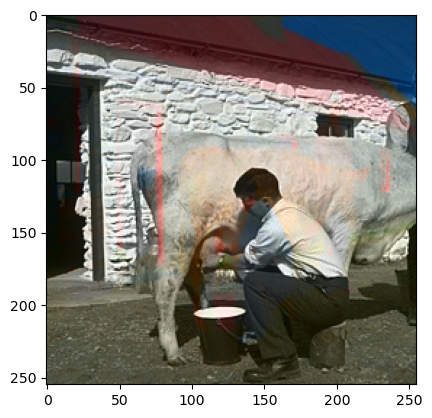

Cropped image:
saved to  cropped_image.png


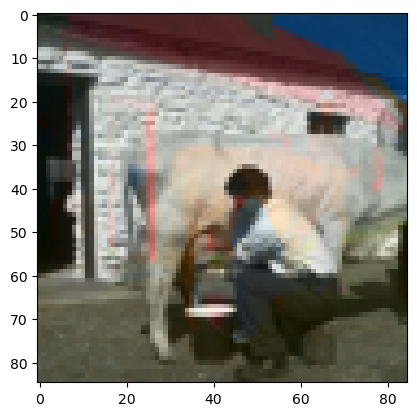

Upscaled cropped image:
saved to  upscaled_cropped_image.png


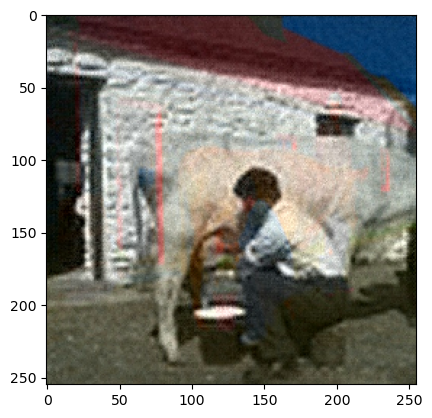

In [36]:
test_comparison(model, 3)

In [39]:
model = load_model("BayesianNet", dataset=dataset, epoch=10, factor=3, device_name=device_name)

Net(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)


In [40]:
for var_scale in [0, 1, 2, 5, 100]:
    set_var_scale(model, var_scale)
    upscale_image(model, input_image, var_scale)

ValueError: not enough values to unpack (expected 2, got 1)